# Kernel method

SVMs are a powerful and flexible class of algorithms used for classification and regression. In this section, we will explore the intuition behind SVMs and their use in classification problems.
To start with, let's understand the basic concept of SVMs. 
Support Vector Machines (SVMs) are supervised learning algorithms that can be used for classification and regression tasks. SVMs try to find the best decision boundary that separates data points of different classes. The decision boundary is chosen such that it maximizes the margin between the data points of different classes.
The margin is defined as the minimum distance between the decision boundary and the closest data points of each class. This makes SVMs very robust to outliers as the decision boundary is chosen based on the data that is closest to it.
In classification problems, the goal is to find a decision boundary that separates the data into two or more classes. SVMs can be used for binary classification, where the classes are only two, or for multiclass classification, where there are more than two classes.

## Motivating Support Vector Machines

In this section we will consider differentiated classification: rather than modelling each category, we simply find a line or curve or flowform that separates these categories from each other.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns
sns.set()

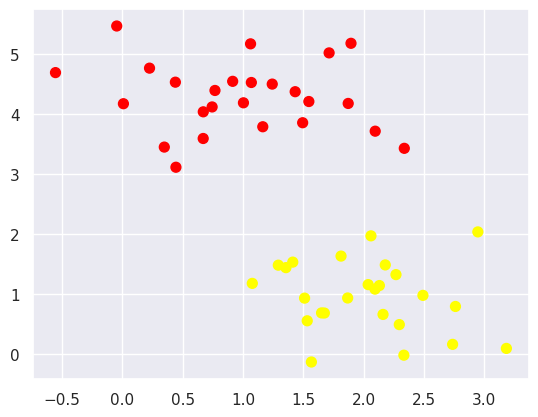

In [2]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

A linear discriminant classifier may draw straight lines to separate two sets of data, but there may be multiple split lines that perfectly distinguish between the two categories. 

This is shown in the diagram below:

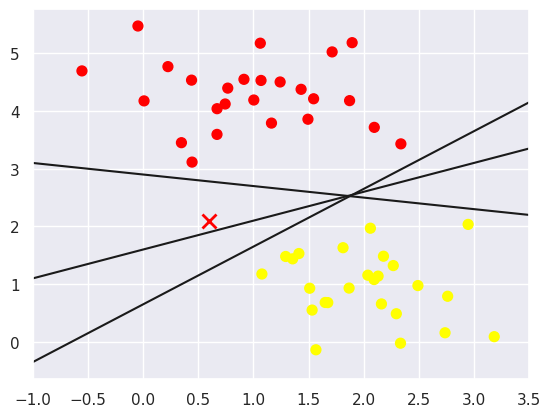

In [3]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

All three separators are good if we want to distinguish between these samples. But they have some significant differences. In the following, I will explain these separators with an example to show the difference between them. Now, suppose you want a new data point, which is marked with an "X" in this graph. So, which separator would you choose? This is a very interesting question! Because you can choose to give this new data point a different label. It's up to you!
Obviously we can't simply "draw a line between classes", but we do need to think a bit deeper.



## Support Vector Machines: Maximizing the _Margin_

SVM proposes a new solution algorithm which finds the nearest straight line by applying an appropriate boundary fill to each line. The following is an example of an improvement to the SVM algorithm.

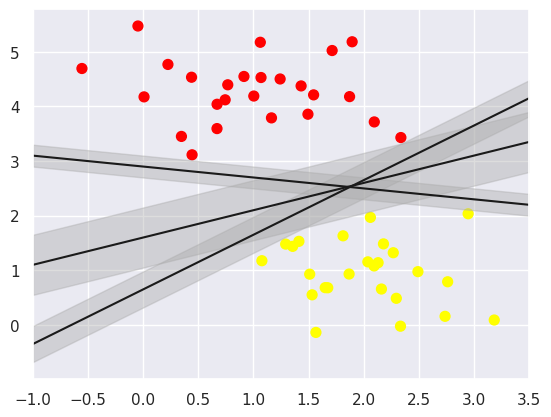

In [4]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

In SVM, the best models are those that maximise this margin, and SVM is an optimal model that achieves the maximum margin and can effectively use the boundary information in the dataset to predict the distribution of new data points, thereby improving prediction accuracy. Because of its excellent fitting ability, SVM can also be used to handle large amounts of unbalanced data.


## Fitting a support vector machine



```{figure} ../../images/svm/svm2d.png
---
name: 'SVM for Linear classification : 2D case'
width: 90%
---
SVM for Linear classification : 2D case. [source](https://online.stat.psu.edu/stat555/node/102/)
```

```{figure} ../../images/svm/svm3d.gif
---
name: 'SVM for Linear classification : 3D case'
width: 90%
---
SVM for Linear classification : 3D case. [source](https://www.youtube.com/watch?v=3liCbRZPrZA)
```


Now we will use a linear kernel and set the C parameter to a large size:

In [5]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y);

Let's create a quick and easy function to draw the SVM decision boundary:

In [6]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

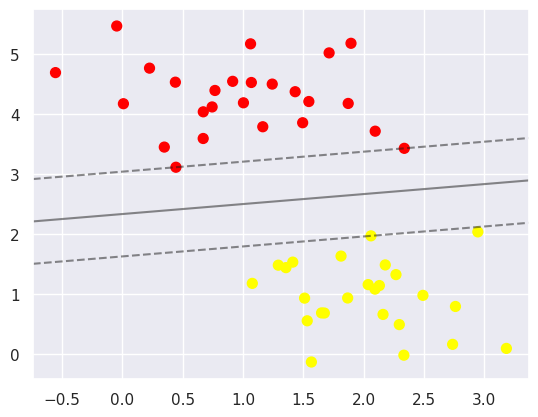

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

This is a maximum expansion of the space between the two points. Note that some of the practice points just reach the boundary and are marked with black circles. Those points are important in the matching process and are called, support vectors, which is the name of this algorithm. In Skeeter-learning, the identification of these points is stored in the support_vectors_ property of the classifier at:

In [8]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

One of the main points of this classification method is that just the space in which the support vector is located has a large effect on the matching result; on the correct side, no point away from the boundary can correct the match. This is due to the fact that during the fitting process those points do not affect the loss function used in the model. Theoretically, this is due to the fact that during the fitting process, those points do not affect the loss function used in the fitting process, and therefore, if they do not cross the boundary, then their location and number are irrelevant.

In the dataset, the first 60 points and the first 120 points are each used as the training set, and we can use this dataset to train the model.

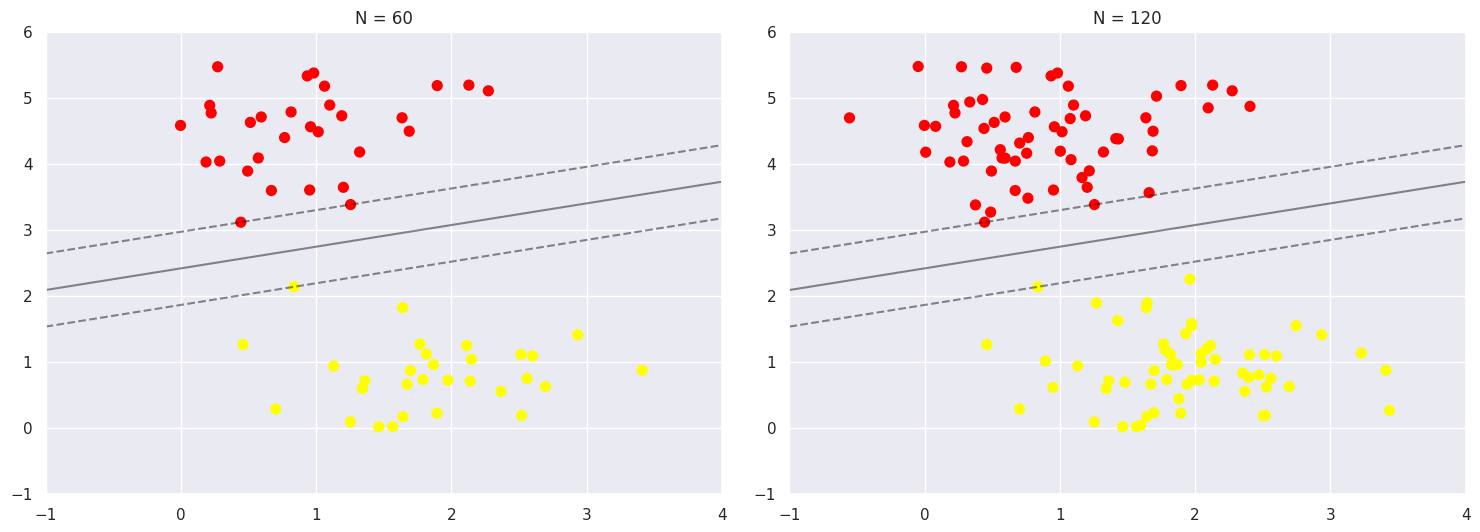

In [9]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

 One of the strengths of the SVM model is that it is insensitive to the exact behaviour of distant points, as can be seen from the comparison between the two figures, and increases the number of training points without affecting the classification results of the model.

With the interactive component in IPython, you can interactively see this feature of the SVM model

In [10]:
from ipywidgets import interact, fixed
interact(plot_svm, N=[10, 200], ax=fixed(None));

interactive(children=(Dropdown(description='N', options=(10, 200), value=10), Output()), _dom_classes=('widget…

## Beyond linear boundaries: Kernel SVM


```{figure} ../../images/svm/svm1.gif
---
name: Kernel SVM visualization
width: 90%
---
Kernel SVM visualization (with a polynomial kernel). [source](https://www.youtube.com/embed/3liCbRZPrZA)
```



Kernels is an "easy algorithm" that saves us from the tedious calculations in a high-dimensional space. If support vector machines and kernels are combined to project data into a high-dimensional space, making it possible to handle non-linear relationships with linear classifiers, the power of SVMs can be enormous.

The following is the case for non-linearly separable data:

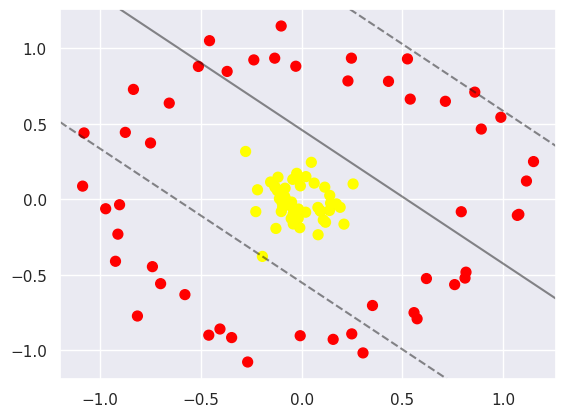

In [11]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

It is possible to project the data into higher dimensions, so that a linear partition line is sufficient. As an example, we can use a simple projection to compute a radial basis function with the centre on the middle block as follows:

In [12]:
r = np.exp(-(X ** 2).sum(1))

This additional dimension of data can be visualised in a 3D diagram.:

In [13]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-90, 90], azip=(-180, 180),
         X=fixed(X), y=fixed(y));

interactive(children=(Dropdown(description='elev', options=(-90, 90), value=-90), IntSlider(value=30, descript…

Next we describe how to select and adjust the radial basis function centres.
This type of basis function transformation is known as a kernel transformation, and this form of transformation solves the problem of shifting the centre of the basis function to a certain extent.
However there is a disadvantage: there is the problem of computational overload as a new basis function needs to be computed each time. We can solve this problem with the help of the "kernel trick" applet, where we change the original linear kernel to a radial basis function kernel and then use the kernel model hyperparameters.

In [14]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y);

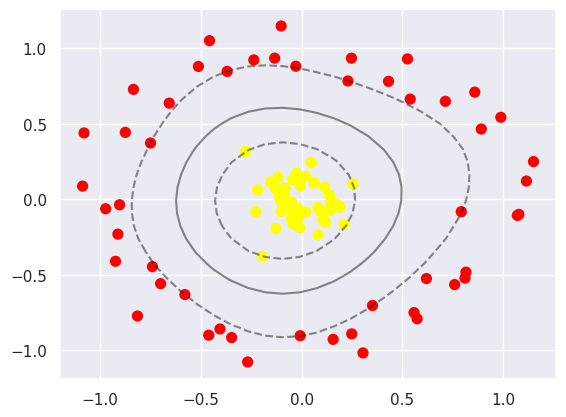

In [15]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

Currently, for linearly divisible data, we usually use a linear support vector machine. However, if the data is non-linear, such as a classification problem, we can transform it into a linearly divisible problem, thus improving the generalisation of the model. In this case, kernel tricks are used to transform linearly divisible problems into non-linearly divisible problems.



## Hinge loss

An alternative to cross-entropy for binary classification problems is the hinge loss function. It is mainly studied for the Support Vector Machine (SVM) model. It is designed to perform binary classification of target values which in the set {-1, 1}

## RBF Kernel

<div class="yt-container">
   <iframe src="https://www.youtube.com/embed/NYwVM6_EuxQ" allowfullscreen></iframe>
</div>

## Support Vector Regression (SVR)

SVR regression (Squeeze-and-VectorRegression), also known as Squeeze Regression, is an optimisation problem. The basic idea is to find a regression plane such that the variables in all data sets are closest to a point on this plane, so that all points on the plane are correlated.
Objective function:
In SVR regression, the objective function is to minimise the two-parametric number of weights while keeping the points in each training set as far away as possible from the support vector on one side of their own category.


```{figure} ../../images/svm/svr1.jpeg
---
name: support vector regression
width: 90%
---
An illustration of support vector regression
```


## SVM v.s. logistic regression

Similarities: Both are linear classification algorithms
Differences:
1. Different loss functions
LR: based on the assumption of "given x and parameters, y obeys binomial distribution", derived from the maximum likelihood estimation
SVM: standard representation of hinge loss ＋ L2 regularization, based on the principle of geometric interval maximization
2. Support vector machines only consider local points near the interval boundary, whereas logistic regression considers the global (points far from the boundary line also play a role in determining the boundary line). Support vector machines do not cause changes in the separation hyperplane by changing the non-support vector samples
3. SVM's loss function is self-regularising, which is why SVM is a structural risk minimisation algorithm!!! And LR must additionally add a regular term to the loss function !!! Structural risk minimisation, meaning seeking a balance between training error and model complexity to prevent overfitting.
4. Optimization methods: LR is generally based on gradient descent, SVM on SMO
5. For non-linear separable problems, SVM is more scalable than LR

```{seealso}
https://www.geeksforgeeks.org/differentiate-between-support-vector-machine-and-logistic-regression/
```

## SVR v.s. linear regression

The problem of overfitting is a very tricky one in the field of statistics. In this case, many machine learning methods, such as least squares (OLSE), will perform poorly. Support vector machines (SVR), on the other hand, can minimise the overfitting problem. SVR allows for non-linear fitting when there is enough data for training.
A final issue to consider is OLSE linear regression. While linear regression is effective for most problems, it is not always effective for some special cases. For example, in OLSE linear regression, there is some bias in fitting the variables linearly because the model is not hyperplane. In contrast, SVR allows for non-linear fitting problems.

## Support Vector Machine Summary
The basic model of SVM: is defined as a linear classifier with maximum interval on the feature space. Specifically, when linearly separable, it finds the optimal classification hyperplane for both classes of samples in the original space. When linearly indistinguishable, relaxation variables are added and samples from a low-dimensional input space are mapped to a higher-dimensional space via a non-linear mapping to make them linearly distinguishable, so that the optimal classification hyperplane can be found in that feature space.

Advantages of SVM:
1) Solves machine learning in the small sample case.
2) No increase in computational complexity when mapping to higher dimensional spaces as the dimensional catastrophe and non-linear differentiability are overcome by using the kernel function approach. (Since the final decision function of the support vector machine algorithm is determined by only a small number of support vectors, the computational complexity depends on the number of support vectors rather than the dimensionality of the entire sample space).
Disadvantages of SVMs:
1) Support vector machine algorithms are difficult to implement for large training samples. This is because support vector algorithms solve support vectors with the help of quadratic programming, which will be designed to compute matrices of order m, so a large amount of machine memory and computing time will be consumed when the order of the matrix is large.
2) The classical SVM only gives algorithms for binary classification, while in data mining, it is generally necessary to solve multi-classification classification problems, and support vector machines are not ideal for solving multi-classification problems.
3) The common SVM theories nowadays use a fixed penalty factor C, but the losses caused by two kinds of errors in positive and negative samples are different.

## [Optional] Let's dive into the math of SVM ...

<div class="yt-container">
   <iframe src="https://www.youtube.com/embed/05VABNfa1ds" allowfullscreen></iframe>
</div>

## Acknowledgement

Some code comes from [jakevdp](https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html), for which the code part is licenced under MIT licence.

<p style="text-align: center;">
<iframe src="../html/svm-vis/demo1/demo.html" width="105%" height="650px;"
style="border:none;"></iframe>
A demo of SVM. <a href="https://cs.stanford.edu/~karpathy/svmjs/demo/">[source]</a>
</p>

<p style="text-align: center;">
<iframe src="../html/svm-vis/demo2/index.html" width="105%" height="600px;"
style="border:none;"></iframe>
A demo of SVM. <a href="http://macheads101.com/demos/svm-playground/">[source]</a>
</p>



## Your turn! 🚀
You can follow this [assignment](../assignments/ml-advanced/kernel-method/kernel-method-assignment-1.ipynb) to practise Support Vector Machines with examples.